In [83]:
# import libraries
import os 
import shutil
import random
import pandas as pd
import cv2
import yaml
import numpy as np
import matplotlib.pyplot as plt

In [30]:
data_dir = '../data'

In [31]:
raw_data_dir = os.path.join(data_dir, 'raw')
processed_data_dir = os.path.join(data_dir, 'processed')

In [32]:
os.makedirs(raw_data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

In [33]:
sudoku_dataset_dir = os.path.join(raw_data_dir, 'sudoku_dataset')
# ! git clone https://github.com/wichtounet/sudoku_dataset.git ../data/raw/sudoku_dataset

In [34]:
sudoku_ocr_dataset_dir = os.path.join(processed_data_dir, 'sudoku_ocr_dataset')
os.makedirs(sudoku_ocr_dataset_dir, exist_ok=True)

In [44]:
localization_dataset_dir = os.path.join(processed_data_dir, 'localization_dataset')
os.makedirs(localization_dataset_dir, exist_ok=True)

In [51]:
localization_image_dir = os.path.join(localization_dataset_dir, 'images')
localization_label_dir = os.path.join(localization_dataset_dir, 'labels')

os.makedirs(localization_image_dir, exist_ok=True)
os.makedirs(localization_label_dir, exist_ok=True)

In [35]:
os.listdir(sudoku_dataset_dir)

['.git',
 '.gitignore',
 'baptiste.sh',
 'datasets',
 'images',
 'jean.sh',
 'mixed',
 'mixed_incomplete',
 'mixed_natural',
 'original',
 'outlines_sorted.csv',
 'README.rst',
 'tools',
 'wip']

In [36]:
image_dir = os.path.join(sudoku_dataset_dir, 'images')

In [37]:
annotation_path = os.path.join(sudoku_dataset_dir, 'outlines_sorted.csv')
annotation_df = pd.read_csv(annotation_path)
annotation_df.head()

,filepath,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,./images/image32.jpg,112,35,583,35,600,435,105,444
1,./images/image1082.jpg,101,270,885,272,872,1060,105,1053
2,./images/image125.jpg,13,11,409,0,423,415,10,427
3,./images/image50.jpg,41,10,552,4,568,443,30,446
4,./images/image188.jpg,14,10,534,9,538,447,20,457


In [38]:
orientation_dict = {
    "image1083": 1,
    "image1024": 2,
    "image1031": 2,
    "image1036": 2,
    "image1037": 2,
    "image1039": 2,
    "image1040": 2,
}

In [40]:
def create_ocr_dataset(): 
        
    for ann_idx, row in annotation_df.iterrows():
        file_path = row['filepath']
        coord_dict = row[row.keys()[1:]].to_dict()
        base_name = os.path.basename(file_path)
        image_path = os.path.join(image_dir, base_name)
        file_name = os.path.splitext(base_name)[0]
    
        orientation = orientation_dict.get(file_name)
            
        data_file_path = os.path.join(image_dir, f'{file_name}.dat')
        image = cv2.imread(image_path)
    
        data = pd.read_csv(data_file_path, delimiter='\t', skiprows=2, names=['data'])
        
        x_min = min(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        x_max = max(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        y_min = min(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
        y_max = max(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
        
        image = image[y_min: y_max, x_min: x_max]
    
        if orientation is not None:
            image = cv2.rotate(image, orientation)
        
        H, W, _ = image.shape
        
        h = int(H/9)
        w = int(W/9)
        
        for idx in range(9):
            file_name = f"{data['data'].iloc[idx].replace(' ', '')}_{ann_idx}.jpg"
            file_path = os.path.join(sudoku_ocr_dataset_dir, file_name)
            row_image = image[idx*h: (idx+1)*h, :]
            cv2.imwrite(file_path, row_image)
        

In [11]:
def get_width_height_stat():
    width_list, height_list = [], []
    
    for ann_idx, row in annotation_df.iterrows():
        coord_dict = row[row.keys()[1:]].to_dict()
        
        x_min = min(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        x_max = max(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        y_min = min(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
        y_max = max(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
    
        width = x_max - x_min
        height = y_max - y_min
        
        width_list.append(width)
        height_list.append(height)
    
    annotation_df['width'] = width_list
    annotation_df['height'] = height_list
    
    print('average weight:', annotation_df['width'].mean())
    print('average height:', annotation_df['height'].mean())

In [64]:
def create_annotations():
    
    for ann_idx, row in annotation_df.iterrows():
    
        file_path = row['filepath']
        coord_dict = row[row.keys()[1:]].to_dict()
    
        base_name = os.path.basename(file_path)
        source_path = os.path.join(image_dir, base_name)
        destination_path = os.path.join(localization_image_dir, base_name)
        file_name = os.path.splitext(base_name)[0]
    
        x_min = min(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        x_max = max(coord_dict['p1_x'], coord_dict['p2_x'], coord_dict['p3_x'], coord_dict['p4_x'])
        y_min = min(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
        y_max = max(coord_dict['p1_y'], coord_dict['p2_y'], coord_dict['p3_y'], coord_dict['p4_y'])
    
        image = cv2.imread(source_path)
        H, W, _ = image.shape
        
        ann_class = 0
        width = x_max - x_min
        height = y_max - y_min
        
        x_center = x_min + (x_max-x_min)/2
        y_center = y_min + (y_max-y_min)/2
    
        x_center = x_center/W
        y_center = y_center/H
        width = width/W
        height = height/H
        
        label_path = os.path.join(localization_label_dir, f'{file_name}.txt')
        fh = open(label_path, 'w')
        fh.write(f'{ann_class} {x_center} {y_center} {width} {height}')
        fh.close()
    
        shutil.copyfile(src=source_path, dst=destination_path)

In [91]:
def split_dataset():

    image_files = os.listdir(localization_image_dir)[1:]
    random.shuffle(image_files)
    dataset_length = len(image_files)
    val_index = int(dataset_length/10)
    val_images, train_images = image_files[:val_index], image_files[val_index:]
    
    len(val_images), len(train_images)
    
    fh = open(os.path.join(localization_dataset_dir, 'train.txt'), 'w')
    for image in train_images:
        fh.write(f'{os.path.abspath(os.path.join(localization_image_dir, image))}\n')
    fh.close()
    
    fh = open(os.path.join(localization_dataset_dir, 'val.txt'), 'w')
    for image in val_images:
        fh.write(f'{os.path.abspath(os.path.join(localization_image_dir, image))}\n')
    fh.close()

In [92]:
# split_dataset()

In [102]:
def create_yaml_file():
    yaml_file = os.path.join(localization_dataset_dir, 'dataset.yaml')
    data = {
        'train': os.path.abspath(os.path.join(localization_dataset_dir, 'train.txt')),
        'val': os.path.abspath(os.path.join(localization_dataset_dir, 'val.txt')),
        'names': {0: 'puzzle'}
    }
    # print(os.path.abspath(os.path.abspath(localization_dataset_dir, 'train.txt')))
    with open(yaml_file, 'w') as file:
        yaml.dump(data, file)

In [103]:
# create_yaml_file()

In [21]:
from ultralytics import YOLO
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os 

In [22]:
localization_model = YOLO(r"C:\Users\shbnd\Desktop\Work\sudoku-solver\models\localization_yolo_model\weights\best.pt")

In [23]:
image = r"C:\Users\shbnd\Downloads\WhatsApp Image 2025-01-31 at 02.14.39_7e73e84a.jpg"
image = r"C:\Users\shbnd\Downloads\WhatsApp Image 2025-02-01 at 21.59.13_3036ea17.jpg"

In [24]:
result = localization_model(image)


image 1/1 C:\Users\shbnd\Downloads\WhatsApp Image 2025-02-01 at 21.59.13_3036ea17.jpg: 640x416 1 puzzle, 200.7ms
Speed: 4.1ms preprocess, 200.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


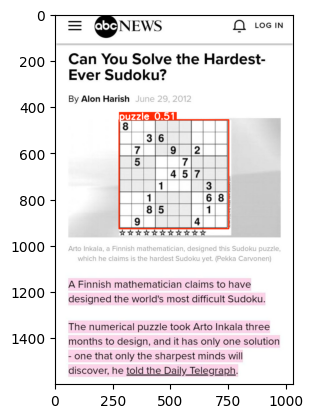

In [25]:
plt.imshow(result[0].plot())

In [26]:
result_json = json.loads(result[0].to_json())

In [27]:
bbox_dict = result_json[0]['box']

In [28]:
bbox_dict

{'x1': 276.33688, 'y1': 457.68842, 'x2': 749.22424, 'y2': 928.33508}

In [29]:
image = cv2.imread(image)

In [30]:
image = image[int(bbox_dict['y1']): int(bbox_dict['y2']), int(bbox_dict['x1']): int(bbox_dict['x2'])]

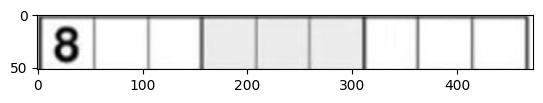

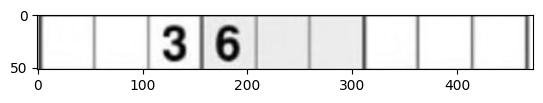

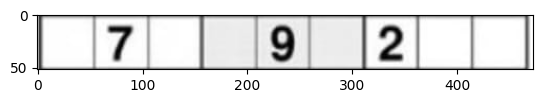

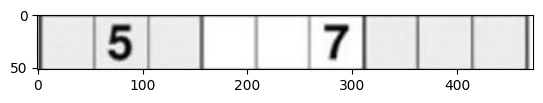

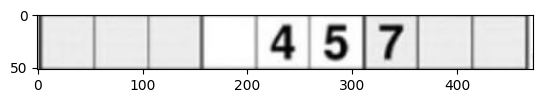

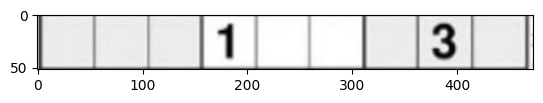

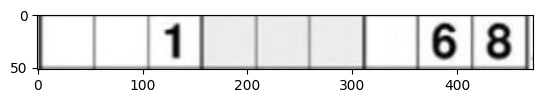

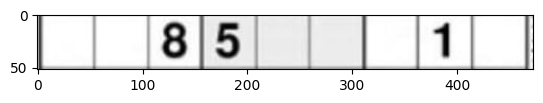

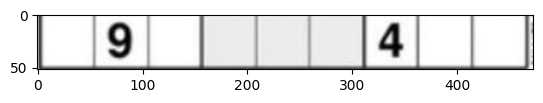

In [31]:
H, W, _ = image.shape

h = int(H/9)
w = int(W/9)

for idx in range(9):
    # file_name = f"{data['data'].iloc[idx].replace(' ', '')}_{ann_idx}.jpg"
    # file_path = os.path.join(sudoku_ocr_dataset_dir, file_name)
    row_image = image[idx*h: (idx+1)*h, :]
    cv2.imwrite(f'image_{idx}.jpg', row_image)
    # plt.title(file_name)
    plt.imshow(row_image)
    plt.show()

In [32]:
import tensorflow as tf
import keras
from keras import ops
from keras import layers
from pathlib import Path
import numpy as np

In [33]:
# ! pip install tensorflow

In [36]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"),
        vals_sparse,
        ops.cast(label_shape, dtype="int64"),
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

img_width = 500
img_height = 50

max_length = 10

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
model = keras.models.load_model('../models/sudoku_ocr.keras', custom_objects={'CTCLayer': CTCLayer})
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



data_dir = Path('../data/processed/sudoku_ocr_dataset/')

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0].split('_')[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

max_length = max([len(label) for label in labels])

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [38]:
# preds = prediction_model.predict(img_1)
# pred_texts = decode_batch_predictions(preds)

# # orig_texts = []
# for label in batch_labels:
#     label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
#     orig_texts.append(label)

# # _, ax = plt.subplots(4, 4, figsize=(15, 5))
# for i in range(len(pred_texts)):
#     img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
#     img = img.T
#     title = f"Prediction: {pred_texts[i]}"
#     plt.title(title)
#     plt.imshow(img, cmap='gray')
#     plt.show()
#     # ax[i // 4, i % 4].imshow(img, cmap="gray")
#     # ax[i // 4, i % 4].set_title(title)
#     # ax[i // 4, i % 4].axis("off")
# plt.show()

In [40]:
# pred_texts

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


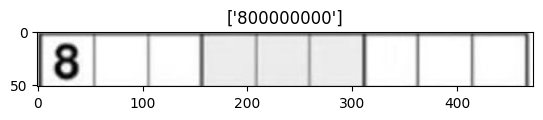

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


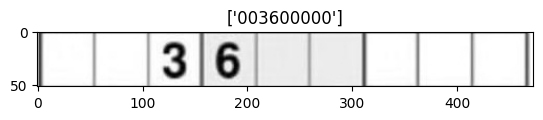

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


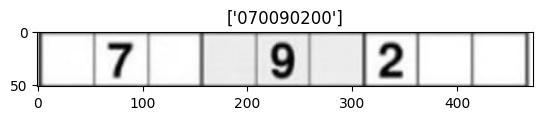

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


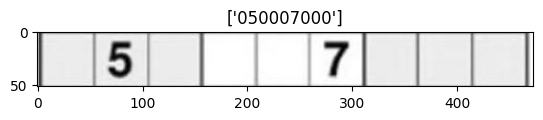

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


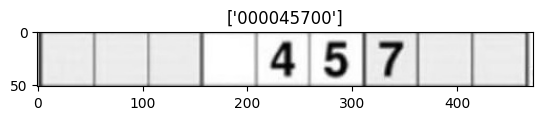

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


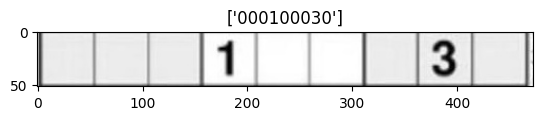

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


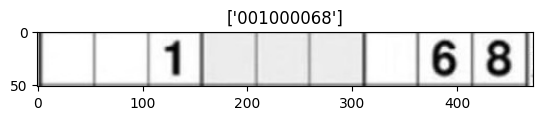

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


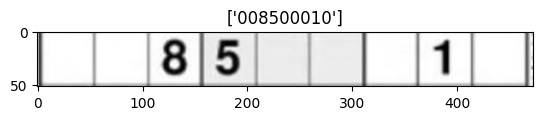

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


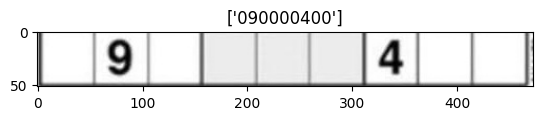

In [41]:
for idx in range(9):
    image_name = f'image_{idx}.jpg'
    image = cv2.imread(image_name)
    img = tf.io.read_file(image_name)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = ops.image.resize(img, [img_height, img_width])
    img = ops.transpose(img, axes=[1, 0, 2])
    img = tf.expand_dims(img, 0)
    preds = prediction_model.predict(img)
    pred_texts = decode_batch_predictions(preds)
    plt.title(pred_texts)
    plt.imshow(image)
    plt.show()

In [100]:
input_len = np.ones(preds.shape[0]) * preds.shape[1]
# Use greedy search. For complex tasks, you can use beam search
results = ctc_decode(preds, input_length=input_len, greedy=True)[0][0][
    :, :max_length
]

In [106]:
ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_length]

<tf.Tensor: shape=(1, 9), dtype=int64, numpy=array([[ 1,  1,  1,  8,  1,  6, 10,  2,  1]], dtype=int64)>

In [109]:
# Iterate over the results and get back the text
output_text = []
for res in results:
    print(res, num_to_char(res), tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8"))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
# return output_text

tf.Tensor([ 1  1  1  8  1  6 10  2  1], shape=(9,), dtype=int64) tf.Tensor([b'0' b'0' b'0' b'7' b'0' b'5' b'9' b'1' b'0'], shape=(9,), dtype=string) 000705910
